In [1]:
from IPython.display import HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
from itertools import product
from pandas.tseries.offsets import DateOffset

import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from copy import deepcopy
import itertools

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from lightgbm import Dataset


In [5]:
import sys
sys.path.append('../..')
from utils.analyze import compute_metrics
from utils.metrics import Bias, Wape, Count, Sum, Mape, MSE

### Data Loading

In [6]:
# train
data = pd.read_csv('data/train.csv')
data['dt'] = pd.to_datetime(data['dt'])

# submission
test_data = pd.read_csv('data/test.csv')
predict_example = pd.read_csv('data/predict_example.csv')

### Constants

In [7]:
mode = 'train' #

if mode == 'submit':
    TRIGGER_DATE = pd.to_datetime('2017-07-01') # первый день для прогноза
    HORIZON = 31
else:
    TRIGGER_DATE = pd.to_datetime('2017-06-01')
    HORIZON = 30

START_TRAIN_DATE = pd.to_datetime('2016-01-02')
END_TRAIN_DATE = TRIGGER_DATE - DateOffset(days=1)

START_PREDICT_DATE = TRIGGER_DATE
END_PREDICT_DATE = TRIGGER_DATE + DateOffset(months=1) - DateOffset(days=1)

print('Mode', mode)
print('TRIGGER data:', TRIGGER_DATE)
print('Start train data:', START_TRAIN_DATE)
print('End train data:', END_TRAIN_DATE)
print('Start predict data:', START_PREDICT_DATE)
print('End predict data:', END_PREDICT_DATE)

Mode train
TRIGGER data: 2017-06-01 00:00:00
Start train data: 2016-01-02 00:00:00
End train data: 2017-05-31 00:00:00
Start predict data: 2017-06-01 00:00:00
End predict data: 2017-06-30 00:00:00


In [8]:
# Make grid
range_date = pd.date_range(START_TRAIN_DATE, END_PREDICT_DATE, freq='D')
unique_shop_id = data['id'].unique().tolist()

train_grid = pd.DataFrame(list(product(unique_shop_id,
                                       range_date)),
                      columns = ['id', 'dt'])

df = train_grid.merge(data, how = 'left', on = ['id', 'dt'])

In [9]:
df['sales'] = df['target'].copy()

df['target'] = df['target'].fillna(0)

# avoid leaking
df.loc[df['dt'] >= TRIGGER_DATE, 'target'] = np.nan 

df['split'] = np.where(df['dt'] >= TRIGGER_DATE, 'test', 'train')
df[df['dt'] >= TRIGGER_DATE].isna().sum()

id          0
dt          0
target    600
sales      95
split       0
dtype: int64

## Feathers

### Calendar feathers

In [10]:
def create_calendar_vars(df, date_col, holidays_list):

    def week_of_month(dt):
        first_day = dt.replace(day=1)
        dom = dt.day
        adjusted_dom = dom + first_day.weekday()
        return int(np.ceil(adjusted_dom / 7.0))

    df_ = df.copy()
    df_['year'] = df_[date_col].dt.year.astype('int')
    df_['quarter'] = df_[date_col].dt.quarter.astype('int')
    df_['month'] = df_[date_col].dt.month.astype('int')
    df_['dayofyear'] = df_[date_col].dt.dayofyear.astype('int')
    df_['dayofmonth'] = df_[date_col].dt.day.astype('int')
    df_['dayofweek'] = df_[date_col].dt.dayofweek.astype('int')
    df_['week'] = df_[date_col].dt.isocalendar().week.astype('int') 
    df_['week'] = df_['week'].astype('int')
    df_['is_weekend'] = pd.Series(df_[date_col]).apply(lambda x : x.weekday() in [5, 6]).values 
    df_['is_weekend'] = df_['is_weekend'].astype('category')
    df_['week_of_month'] = pd.Series(df_[date_col]).apply(week_of_month).values
    df_['week_of_month'] = df_['week_of_month'].astype('int')
    
    df_['first_day_month'] = df_['dayofmonth'].apply(lambda x: x == 1).astype('category')
    df_['second_day_month'] = df_['dayofmonth'].apply(lambda x: x == 2).astype('category')

    df_['is_evenweek'] = df_['week'] // 2 == 0 
    df_['is_evenweek'] = df_['is_evenweek'].astype('category')

    df_['week_of_month + day_of_week'] = df_['week_of_month'].astype('str') + '-'  + df_['dayofweek'].astype('str')
    df_['week_of_month + day_of_week'] = df_['week_of_month + day_of_week'].astype('category')

    df_['week_of_month + week'] = df_['week_of_month'].astype('str') + '-'  + df_['week'].astype('str')
    df_['week_of_month + week'] = df_['week_of_month + week'].astype('category')

    df_['month + dayofmonth'] = df_['month'].astype('str') + '-'  + df_['dayofmonth'].astype('str') 
    df_['month + dayofmonth'] = df_['month + dayofmonth'].astype('category')

    df_['week + quarter'] = df_['week'].astype('str') + '-'  + df_['quarter'].astype('str') 
    df_['week + quarter'] = df_['week + quarter'].astype('category')
    
    df_['dayofmonth + quarter'] = df_['dayofmonth'].astype('str') + '-'  + df_['quarter'].astype('str')
    df_['dayofmonth + quarter'] = df_['dayofmonth + quarter'].astype('category')
    
    df_['is_evenweek + dayofweek'] = df_['is_evenweek'].astype('str') + '-'  + df_['dayofweek'].astype('str')
    df_['is_evenweek + dayofweek'] = df_['is_evenweek + dayofweek'].astype('category')
    


    return df_


# 
holidays_list = []

In [11]:
df = create_calendar_vars(df, date_col='dt', holidays_list=holidays_list)

In [12]:
df['id'] = df['id'].astype('category')

### Long Lags

In [13]:
lags_range = np.arange(HORIZON, 366, 28) 

for lag in lags_range:
    df[f'Lags_Long_{lag}'] = df.groupby(['id',])['target'].shift(lag)
    print(f'Lags_Long_{lag}')


Lags_Long_30
Lags_Long_58
Lags_Long_86
Lags_Long_114
Lags_Long_142
Lags_Long_170
Lags_Long_198
Lags_Long_226
Lags_Long_254
Lags_Long_282
Lags_Long_310
Lags_Long_338


### Short Lags

In [14]:
lags_range = np.arange(28, 45, 1) #0.2712

for lag in lags_range:
    df[f'Lags_Short_{lag}'] = df.groupby(['id',])['target'].shift(lag)
    print(f'Lags_Short_{lag}')

Lags_Short_28
Lags_Short_29
Lags_Short_30
Lags_Short_31
Lags_Short_32
Lags_Short_33
Lags_Short_34
Lags_Short_35
Lags_Short_36
Lags_Short_37
Lags_Short_38
Lags_Short_39
Lags_Short_40
Lags_Short_41
Lags_Short_42
Lags_Short_43
Lags_Short_44


### Diffs

In [15]:
df[f'Diff_7_lag_0'] = df.groupby('id')['Lags_Short_30'].diff(7)
df[f'Diff_7_lag_35'] = df.groupby('id')['Lags_Short_35'].diff(7)
df[f'Diff_7_lag_42'] = df.groupby('id')['Lags_Short_42'].diff(7)
df[f'Diff_7_lag_91'] = df.groupby('id')['Lags_Long_338'].diff(7)

In [16]:
df[f'Diff_14_lag_30'] = df.groupby('id')['Lags_Short_30'].diff(14)
df[f'Diff_14_lag_35'] = df.groupby('id')['Lags_Short_35'].diff(14)
df[f'Diff_14_lag_42'] = df.groupby('id')['Lags_Short_42'].diff(14)
df[f'Diff_14_lag_91'] = df.groupby('id')['Lags_Long_338'].diff(14)

### Ratio

In [17]:
df['Ratio_1'] = df['Lags_Short_38'] / df['Lags_Short_31']
df['Ratio_2'] = df['Lags_Short_39'] / df['Lags_Short_32']
df['Ratio_3'] = df['Lags_Short_40'] / df['Lags_Short_33']
df['Ratio_4'] = df['Lags_Short_41'] / df['Lags_Short_34']
df['Ratio_5'] = df['Lags_Short_42'] / df['Lags_Short_35']
df['Ratio_6'] = df['Lags_Short_43'] / df['Lags_Short_36']
df['Ratio_7'] = df['Lags_Short_44'] / df['Lags_Short_37']

### Group Statistics

In [18]:
# Mean
df['mean_id'] = df.groupby(['id'])['target'].transform(lambda x: x.mean())
df['mean_year'] = df.groupby(['year'])['target'].transform(lambda x: x.mean())
df['mean_quarter'] = df.groupby(['quarter'])['target'].transform(lambda x: x.mean())
df['mean_month'] = df.groupby(['month'])['target'].transform(lambda x: x.mean())
df['mean_dayofyear'] = df.groupby(['dayofyear'])['target'].transform(lambda x: x.mean())
df['mean_dayofmonth'] = df.groupby(['dayofmonth'])['target'].transform(lambda x: x.mean())
df['mean_dayofweek'] = df.groupby(['dayofweek'])['target'].transform(lambda x: x.mean())
df['mean_week'] = df.groupby(['week'])['target'].transform(lambda x: x.mean())
df['mean_week_of_month'] = df.groupby(['week_of_month'])['target'].transform(lambda x: x.mean())
df['mean_is_evenweek'] = df.groupby(['is_evenweek'])['target'].transform(lambda x: x.mean())
df['mean_week_of_month + day_of_week'] = df.groupby(['week_of_month + day_of_week'])['target'].transform(lambda x: x.mean())
df['mean_week_of_month + week'] = df.groupby(['week_of_month + week'])['target'].transform(lambda x: x.mean())
df['mean_month + dayofmonth'] = df.groupby(['month + dayofmonth'])['target'].transform(lambda x: x.mean())
df['mean_week + quarter'] = df.groupby(['week + quarter'])['target'].transform(lambda x: x.mean())
df['mean_dayofmonth + quarter'] = df.groupby(['dayofmonth + quarter'])['target'].transform(lambda x: x.mean())
df['mean_is_evenweek + dayofweek'] = df.groupby(['is_evenweek + dayofweek'])['target'].transform(lambda x: x.mean())

In [19]:
# Sum
df['sum_id'] = df.groupby(['id'])['target'].transform(lambda x: x.sum())
df['sum_year'] = df.groupby(['year'])['target'].transform(lambda x: x.sum())
df['sum_quarter'] = df.groupby(['quarter'])['target'].transform(lambda x: x.sum())
df['sum_month'] = df.groupby(['month'])['target'].transform(lambda x: x.sum())
df['sum_dayofyear'] = df.groupby(['dayofyear'])['target'].transform(lambda x: x.sum())
df['sum_dayofmonth'] = df.groupby(['dayofmonth'])['target'].transform(lambda x: x.sum())
df['sum_dayofweek'] = df.groupby(['dayofweek'])['target'].transform(lambda x: x.sum())
df['sum_week'] = df.groupby(['week'])['target'].transform(lambda x: x.sum())
df['sum_week_of_month'] = df.groupby(['week_of_month'])['target'].transform(lambda x: x.sum())
df['sum_is_evenweek'] = df.groupby(['is_evenweek'])['target'].transform(lambda x: x.sum())
df['sum_week_of_month + day_of_week'] = df.groupby(['week_of_month + day_of_week'])['target'].transform(lambda x: x.sum())
df['sum_week_of_month + week'] = df.groupby(['week_of_month + week'])['target'].transform(lambda x: x.sum())
df['sum_month + dayofmonth'] = df.groupby(['month + dayofmonth'])['target'].transform(lambda x: x.sum())
df['sum_week + quarter'] = df.groupby(['week + quarter'])['target'].transform(lambda x: x.sum())
df['sum_dayofmonth + quarter'] = df.groupby(['dayofmonth + quarter'])['target'].transform(lambda x: x.sum())
df['sum_is_evenweek + dayofweek'] = df.groupby(['is_evenweek + dayofweek'])['target'].transform(lambda x: x.sum())



In [20]:
# Min
df['min_id'] = df.groupby(['id'])['target'].transform(lambda x: x.min())
df['min_year'] = df.groupby(['year'])['target'].transform(lambda x: x.min())
df['min_quarter'] = df.groupby(['quarter'])['target'].transform(lambda x: x.min())
df['min_month'] = df.groupby(['month'])['target'].transform(lambda x: x.min())
df['min_dayofyear'] = df.groupby(['dayofyear'])['target'].transform(lambda x: x.min())
df['min_dayofmonth'] = df.groupby(['dayofmonth'])['target'].transform(lambda x: x.min())
df['min_dayofweek'] = df.groupby(['dayofweek'])['target'].transform(lambda x: x.min())
df['min_week'] = df.groupby(['week'])['target'].transform(lambda x: x.min())
df['min_week_of_month'] = df.groupby(['week_of_month'])['target'].transform(lambda x: x.min())
df['min_is_evenweek'] = df.groupby(['is_evenweek'])['target'].transform(lambda x: x.min())
df['min_week_of_month + day_of_week'] = df.groupby(['week_of_month + day_of_week'])['target'].transform(lambda x: x.min())
df['min_week_of_month + week'] = df.groupby(['week_of_month + week'])['target'].transform(lambda x: x.min())
df['min_month + dayofmonth'] = df.groupby(['month + dayofmonth'])['target'].transform(lambda x: x.min())
df['min_week + quarter'] = df.groupby(['week + quarter'])['target'].transform(lambda x: x.min())
df['min_dayofmonth + quarter'] = df.groupby(['dayofmonth + quarter'])['target'].transform(lambda x: x.min())
df['min_is_evenweek + dayofweek'] = df.groupby(['is_evenweek + dayofweek'])['target'].transform(lambda x: x.min())

In [21]:
# Max
df['max_id'] = df.groupby(['id'])['target'].transform(lambda x: x.max())
df['max_year'] = df.groupby(['year'])['target'].transform(lambda x: x.max())
df['max_quarter'] = df.groupby(['quarter'])['target'].transform(lambda x: x.max())
df['max_month'] = df.groupby(['month'])['target'].transform(lambda x: x.max())
df['max_dayofyear'] = df.groupby(['dayofyear'])['target'].transform(lambda x: x.max())
df['max_dayofmonth'] = df.groupby(['dayofmonth'])['target'].transform(lambda x: x.max())
df['max_dayofweek'] = df.groupby(['dayofweek'])['target'].transform(lambda x: x.max())
df['max_week'] = df.groupby(['week'])['target'].transform(lambda x: x.max())
df['max_week_of_month'] = df.groupby(['week_of_month'])['target'].transform(lambda x: x.max())
df['max_is_evenweek'] = df.groupby(['is_evenweek'])['target'].transform(lambda x: x.max())
df['max_week_of_month + day_of_week'] = df.groupby(['week_of_month + day_of_week'])['target'].transform(lambda x: x.max())
df['max_week_of_month + week'] = df.groupby(['week_of_month + week'])['target'].transform(lambda x: x.max())
df['max_month + dayofmonth'] = df.groupby(['month + dayofmonth'])['target'].transform(lambda x: x.max())
df['max_week + quarter'] = df.groupby(['week + quarter'])['target'].transform(lambda x: x.max())
df['max_dayofmonth + quarter'] = df.groupby(['dayofmonth + quarter'])['target'].transform(lambda x: x.max())
df['max_is_evenweek + dayofweek'] = df.groupby(['is_evenweek + dayofweek'])['target'].transform(lambda x: x.max())

In [22]:
# Mean by ID
df['mean_year_id'] = df.groupby(['year', 'id'])['target'].transform(lambda x: x.mean())
df['mean_quarter_id'] = df.groupby(['quarter', 'id'])['target'].transform(lambda x: x.mean())
df['mean_month_id'] = df.groupby(['month', 'id'])['target'].transform(lambda x: x.mean())
df['mean_dayofyear_id'] = df.groupby(['dayofyear', 'id'])['target'].transform(lambda x: x.mean())
df['mean_dayofmonth_id'] = df.groupby(['dayofmonth', 'id'])['target'].transform(lambda x: x.mean())
df['mean_dayofweek_id'] = df.groupby(['dayofweek', 'id'])['target'].transform(lambda x: x.mean())
df['mean_week_id'] = df.groupby(['week', 'id'])['target'].transform(lambda x: x.mean())
df['mean_week_of_month_id'] = df.groupby(['week_of_month', 'id'])['target'].transform(lambda x: x.mean())
df['mean_is_evenweek_id'] = df.groupby(['is_evenweek', 'id'])['target'].transform(lambda x: x.mean())
df['mean_week_of_month + day_of_week_id'] = df.groupby(['week_of_month + day_of_week', 'id'])['target'].transform(lambda x: x.mean())
df['mean_week_of_month + week_id'] = df.groupby(['week_of_month + week', 'id'])['target'].transform(lambda x: x.mean())
df['mean_month + dayofmonth_id'] = df.groupby(['month + dayofmonth', 'id'])['target'].transform(lambda x: x.mean())
df['mean_week + quarter_id'] = df.groupby(['week + quarter', 'id'])['target'].transform(lambda x: x.mean())
df['mean_dayofmonth + quarter_id'] = df.groupby(['dayofmonth + quarter', 'id'])['target'].transform(lambda x: x.mean())
df['mean_is_evenweek + dayofweek_id'] = df.groupby(['is_evenweek + dayofweek', 'id'])['target'].transform(lambda x: x.mean())

In [23]:
# Sum by ID
df['sum_year_id'] = df.groupby(['year', 'id'])['target'].transform(lambda x: x.sum())
df['sum_quarter_id'] = df.groupby(['quarter', 'id'])['target'].transform(lambda x: x.sum())
df['sum_month_id'] = df.groupby(['month', 'id'])['target'].transform(lambda x: x.sum())
df['sum_dayofyear_id'] = df.groupby(['dayofyear', 'id'])['target'].transform(lambda x: x.sum())
df['sum_dayofmonth_id'] = df.groupby(['dayofmonth', 'id'])['target'].transform(lambda x: x.sum())
df['sum_dayofweek_id'] = df.groupby(['dayofweek', 'id'])['target'].transform(lambda x: x.sum())
df['sum_week_id'] = df.groupby(['week', 'id'])['target'].transform(lambda x: x.sum())
df['sum_week_of_month_id'] = df.groupby(['week_of_month', 'id'])['target'].transform(lambda x: x.sum())
df['sum_is_evenweek_id'] = df.groupby(['is_evenweek', 'id'])['target'].transform(lambda x: x.sum())
df['sum_week_of_month + day_of_week_id'] = df.groupby(['week_of_month + day_of_week', 'id'])['target'].transform(lambda x: x.sum())
df['sum_week_of_month + week_id'] = df.groupby(['week_of_month + week', 'id'])['target'].transform(lambda x: x.sum())
df['sum_month + dayofmonth_id'] = df.groupby(['month + dayofmonth', 'id'])['target'].transform(lambda x: x.sum())
df['sum_week + quarter_id'] = df.groupby(['week + quarter', 'id'])['target'].transform(lambda x: x.sum())
df['sum_dayofmonth + quarter_id'] = df.groupby(['dayofmonth + quarter', 'id'])['target'].transform(lambda x: x.sum())
df['sum_is_evenweek + dayofweek_id'] = df.groupby(['is_evenweek + dayofweek', 'id'])['target'].transform(lambda x: x.sum())

In [24]:
# Min by ID
df['min_year_id'] = df.groupby(['year', 'id'])['target'].transform(lambda x: x.min())
df['min_quarter_id'] = df.groupby(['quarter', 'id'])['target'].transform(lambda x: x.min())
df['min_month_id'] = df.groupby(['month', 'id'])['target'].transform(lambda x: x.min())
df['min_dayofyear_id'] = df.groupby(['dayofyear', 'id'])['target'].transform(lambda x: x.min())
df['min_dayofmonth_id'] = df.groupby(['dayofmonth', 'id'])['target'].transform(lambda x: x.min())
df['min_dayofweek_id'] = df.groupby(['dayofweek', 'id'])['target'].transform(lambda x: x.min())
df['min_week_id'] = df.groupby(['week', 'id'])['target'].transform(lambda x: x.min())
df['min_week_of_month_id'] = df.groupby(['week_of_month', 'id'])['target'].transform(lambda x: x.min())
df['min_is_evenweek_id'] = df.groupby(['is_evenweek', 'id'])['target'].transform(lambda x: x.min())
df['min_week_of_month + day_of_week_id'] = df.groupby(['week_of_month + day_of_week', 'id'])['target'].transform(lambda x: x.min())
df['min_week_of_month + week_id'] = df.groupby(['week_of_month + week', 'id'])['target'].transform(lambda x: x.min())
df['min_month + dayofmonth_id'] = df.groupby(['month + dayofmonth', 'id'])['target'].transform(lambda x: x.min())
df['min_week + quarter_id'] = df.groupby(['week + quarter', 'id'])['target'].transform(lambda x: x.min())
df['min_dayofmonth + quarter_id'] = df.groupby(['dayofmonth + quarter', 'id'])['target'].transform(lambda x: x.min())
df['min_is_evenweek + dayofweek_id'] = df.groupby(['is_evenweek + dayofweek', 'id'])['target'].transform(lambda x: x.min())

In [25]:
# Maxby ID
df['max_year_id'] = df.groupby(['year', 'id'])['target'].transform(lambda x: x.max())
df['max_quarter_id'] = df.groupby(['quarter', 'id'])['target'].transform(lambda x: x.max())
df['max_month_id'] = df.groupby(['month', 'id'])['target'].transform(lambda x: x.max())
df['max_dayofyear_id'] = df.groupby(['dayofyear', 'id'])['target'].transform(lambda x: x.max())
df['max_dayofmonth_id'] = df.groupby(['dayofmonth', 'id'])['target'].transform(lambda x: x.max())
df['max_dayofweek_id'] = df.groupby(['dayofweek', 'id'])['target'].transform(lambda x: x.max())
df['max_week_id'] = df.groupby(['week', 'id'])['target'].transform(lambda x: x.max())
df['max_week_of_month_id'] = df.groupby(['week_of_month', 'id'])['target'].transform(lambda x: x.max())
df['max_is_evenweek_id'] = df.groupby(['is_evenweek', 'id'])['target'].transform(lambda x: x.max())
df['max_week_of_month + day_of_week_id'] = df.groupby(['week_of_month + day_of_week', 'id'])['target'].transform(lambda x: x.max())
df['max_week_of_month + week_id'] = df.groupby(['week_of_month + week', 'id'])['target'].transform(lambda x: x.max())
df['max_month + dayofmonth_id'] = df.groupby(['month + dayofmonth', 'id'])['target'].transform(lambda x: x.max())
df['max_week + quarter_id'] = df.groupby(['week + quarter', 'id'])['target'].transform(lambda x: x.max())
df['max_dayofmonth + quarter_id'] = df.groupby(['dayofmonth + quarter', 'id'])['target'].transform(lambda x: x.max())
df['max_is_evenweek + dayofweek_id'] = df.groupby(['is_evenweek + dayofweek', 'id'])['target'].transform(lambda x: x.max())

In [26]:
df.head().T.head(25)

,0,1,2,3,4
id,0,0,0,0,0
dt,2016-01-02 00:00:00,2016-01-03 00:00:00,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-06 00:00:00
target,747.8,681.2,505.8,0,1078.3
sales,747.8,681.2,505.8,NaN,1078.3
split,train,train,train,train,train
year,2016,2016,2016,2016,2016
quarter,1,1,1,1,1
month,1,1,1,1,1
dayofyear,2,3,4,5,6
dayofmonth,2,3,4,5,6


### Rolling Means

In [27]:
features_main = ['id', 'year', 'month', 'dayofyear', 'dayofmonth', 'dayofweek', 'week', 'is_weekend', 'week_of_month', 'is_evenweek']

In [29]:
# create possible combinations
features_combinations = [com for sub in range(1, 4) for com in itertools.combinations(features_main, sub)]

In [31]:
for comb in features_combinations:

    df[f'rolling_mean_{comb[0]}_{comb[0]}'] = df.groupby(list(comb))['target'].transform(
        lambda s: s.shift(HORIZON).rolling(window=4, min_periods=1, center=False).agg('mean'))
    
    df[f'rolling_sum_{comb[0]}_{comb[0]}'] = df.groupby(list(comb))['target'].transform(
        lambda s: s.shift(HORIZON).rolling(window=4, min_periods=1, center=False).agg('sum'))
    
    df[f'rolling_median_{comb[0]}_{comb[0]}'] = df.groupby(list(comb))['target'].transform(
        lambda s: s.shift(HORIZON).rolling(window=4, min_periods=1, center=False).agg('median'))
    
    df[f'rolling_min_{comb[0]}_{comb[0]}'] = df.groupby(list(comb))['target'].transform(
        lambda s: s.shift(HORIZON).rolling(window=4, min_periods=1, center=False).agg('min'))
    
    df[f'rolling_max_{comb[0]}_{comb[0]}'] = df.groupby(list(comb))['target'].transform(
        lambda s: s.shift(HORIZON).rolling(window=4, min_periods=1, center=False).agg('max'))

In [33]:
df.head()

,id,dt,target,sales,split,year,quarter,month,dayofyear,dayofmonth,...,rolling_mean_week_of_month_week_of_month,rolling_sum_week_of_month_week_of_month,rolling_median_week_of_month_week_of_month,rolling_min_week_of_month_week_of_month,rolling_max_week_of_month_week_of_month,rolling_mean_is_evenweek_is_evenweek,rolling_sum_is_evenweek_is_evenweek,rolling_median_is_evenweek_is_evenweek,rolling_min_is_evenweek_is_evenweek,rolling_max_is_evenweek_is_evenweek
0,0,2016-01-02,747.8,747.8,train,2016,1,1,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2016-01-03,681.2,681.2,train,2016,1,1,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2016-01-04,505.8,505.8,train,2016,1,1,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2016-01-05,0.0,NaN,train,2016,1,1,5,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2016-01-06,1078.3,1078.3,train,2016,1,1,6,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df.shape

(10920, 241)

In [32]:
df.to_csv('data/extened_df.csv')

We've created lots of features. Lets filter them.

## Feature Selection

In [282]:
mask_na = (df['dt'] >= pd.to_datetime('2016-07-01')) & (df['dt'] < pd.to_datetime('2017-01-01')) & (df['id'].isin([4, 8, 10, 13, 17]))
df = df[~mask_na]

### Feature Permutation

In [283]:
real_features = df.columns.tolist()

for col in ['dt', 'target', 'sales', 'split']:
    real_features.remove(col)

In [284]:
synthetic_features = ['synthetic__' + i for i in real_features]
concat_features = real_features + synthetic_features
len(concat_features)

474

In [285]:
# Создадим синтетический набор с перемешанными фичами
synthetic_df = df[real_features].copy()
synthetic_df.columns = synthetic_features

# перемешаем синтетические фичи как следует
for feature in synthetic_features:
    np.random.shuffle(synthetic_df[feature].values)

In [286]:
new_df = pd.concat((synthetic_df, df[real_features + ['dt', 'target', 'sales', 'split']]), axis=1)


In [287]:
# Train & Test Split
train = new_df[(new_df['split'] == 'train')]
test = new_df[new_df['split'] == 'test']

In [288]:
VALID_SIZE = 0.2
np.random.seed(0)

# индексы для валидационного набора -- выберем из тренйна рандомно несоклько дней для валидации
valid_size = np.ceil(len(train) * VALID_SIZE).astype(int)
print('Кол-во наблюдений на валидации', valid_size)

valid_idx = np.random.choice(train.index, valid_size, replace = False)
valid = train.loc[valid_idx]

# удалим из трейна валидационныее дни
train.drop(valid_idx, axis = 0, inplace = True)

Кол-во наблюдений на валидации 1880


In [289]:
# Определим категорильные фичи
cat_columns = train[concat_features].select_dtypes(include='category').columns.tolist()
print(cat_columns)

# формируем датасеты для lgbm
train_ds = lgb.Dataset(train[concat_features],
                       train['target'],
                       categorical_feature=cat_columns,
                       )

val_ds = lgb.Dataset(valid[concat_features],
                     valid['target'],
                     categorical_feature=cat_columns,
                      reference=train_ds
                     )

['id', 'is_weekend', 'first_day_month', 'second_day_month', 'is_evenweek', 'week_of_month + day_of_week', 'week_of_month + week', 'month + dayofmonth', 'week + quarter', 'dayofmonth + quarter', 'is_evenweek + dayofweek', 'synthetic__id', 'synthetic__is_weekend', 'synthetic__first_day_month', 'synthetic__second_day_month', 'synthetic__is_evenweek', 'synthetic__week_of_month + day_of_week', 'synthetic__week_of_month + week', 'synthetic__month + dayofmonth', 'synthetic__week + quarter', 'synthetic__dayofmonth + quarter', 'synthetic__is_evenweek + dayofweek']


In [290]:
params = {
    'objective': 'mae', #'quantile', 'mae'
    'eta': 0.01, # 0.1
    'max_depth' : 5,
    'seed' : 42, 
    'verbose' : -1,
     'num_threads': 8,
    'early_stopping_rounds':200
}


In [291]:
# Сюда будем записывать значение метрик на валидации и трейне
evals_result = {}

# Обучаем модель
model = lgb.train(params,
                  train_ds,
                  num_boost_round = 1000,
                  valid_sets=[train_ds, val_ds],
                  verbose_eval=50,
                  evals_result=evals_result,
                  )

Training until validation scores don't improve for 200 rounds
[50]	training's l1: 185.611	valid_1's l1: 180.211
[100]	training's l1: 135.215	valid_1's l1: 129.299
[150]	training's l1: 99.5265	valid_1's l1: 94.3195
[200]	training's l1: 77.8712	valid_1's l1: 73.421
[250]	training's l1: 63.7049	valid_1's l1: 59.4108
[300]	training's l1: 55.1177	valid_1's l1: 51.2636
[350]	training's l1: 49.1503	valid_1's l1: 46.0102
[400]	training's l1: 45.4921	valid_1's l1: 42.6581
[450]	training's l1: 43.0694	valid_1's l1: 40.6364
[500]	training's l1: 41.4385	valid_1's l1: 39.3492
[550]	training's l1: 39.2191	valid_1's l1: 37.5556
[600]	training's l1: 38.2553	valid_1's l1: 36.8532
[650]	training's l1: 36.3425	valid_1's l1: 35.3632
[700]	training's l1: 33.8625	valid_1's l1: 33.4182
[750]	training's l1: 32.1493	valid_1's l1: 32.1304
[800]	training's l1: 30.8916	valid_1's l1: 31.2142
[850]	training's l1: 29.8678	valid_1's l1: 30.5324
[900]	training's l1: 29.3632	valid_1's l1: 30.1431
[950]	training's l1: 2

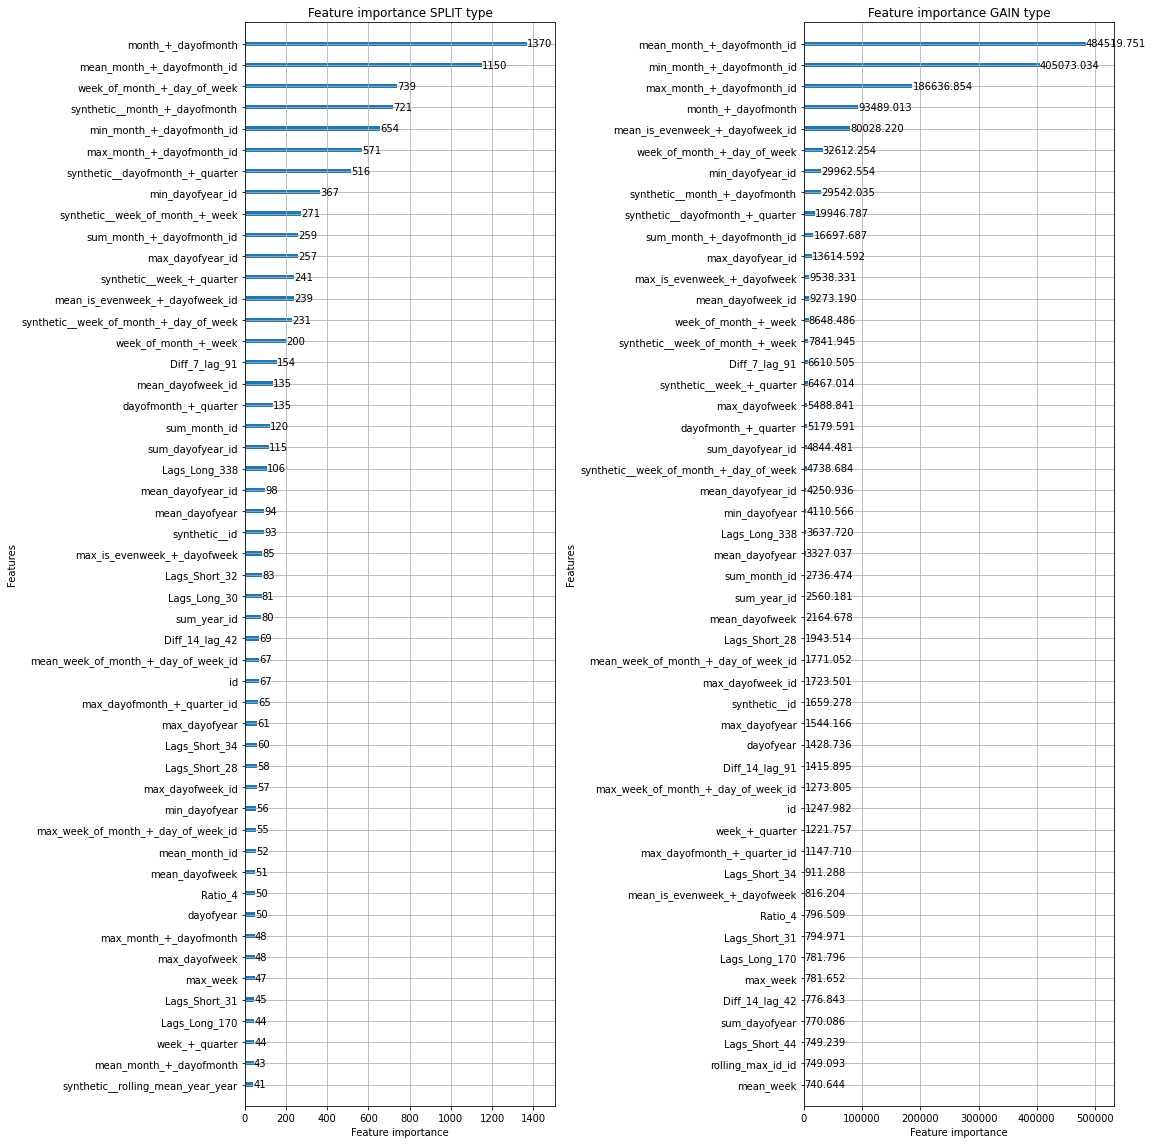

In [292]:
fig, axes = plt.subplots(1, 2, figsize = (16, 16))
lgb.plot_importance(model, ax = axes[0], title='Feature importance SPLIT type',
                    importance_type='split', max_num_features=50)
lgb.plot_importance(model, ax = axes[1], title='Feature importance GAIN type', 
                    importance_type='gain', max_num_features=50)


plt.tight_layout()

In [293]:
feature_imp = model.feature_importance(importance_type='gain')

In [294]:
len(concat_features), len(feature_imp)

(474, 474)

In [295]:
feature_imp_df = pd.DataFrame({'feature': concat_features,
                              'importance': feature_imp })
feature_imp_df = feature_imp_df.sort_values(by=['importance'], ascending = False).reset_index(drop=True)

In [296]:
synthetic_imp = feature_imp_df[feature_imp_df['feature'].isin(synthetic_features)]['importance'].median()

In [297]:
left_features = feature_imp_df[feature_imp_df['importance'] > synthetic_imp]['feature'].tolist()

features2train = list(set(left_features) - set(synthetic_features))
len(features2train)

146

### Замерим качество

In [298]:
# Train & Test Split
train = df[(df['split'] == 'train')]
test = df[df['split'] == 'test']

In [299]:

cat_columns = train[features2train].select_dtypes(include='category').columns.tolist()
print(cat_columns)



# формируем датасеты для lgbm
train_ds = lgb.Dataset(train[features2train],
                       train['target'],
#                        categorical_feature=cat_columns,
                       )

val_ds = lgb.Dataset(valid[features2train],
                     valid['target'],
#                      categorical_feature=cat_columns,
                      reference=train_ds
                     )

['week_of_month + week', 'id', 'week_of_month + day_of_week', 'week + quarter', 'month + dayofmonth', 'dayofmonth + quarter']


In [300]:
params = {
    'objective': 'mae', #'quantile',
#     'alpha': 0.52,
    'eta': 0.01, # 0.1
    'max_depth' : -1,
    'seed' : 42, 
    'verbose' : -1,
     'num_threads': 8,
    'early_stopping_rounds':200
}

In [301]:
# Сюда будем записывать значение метрик на валидации и трейне
evals_result = {}

# Обучаем модель
model = lgb.train(params,
                  train_ds,
                  num_boost_round = 1000,
                  valid_sets=[train_ds, val_ds],
                  verbose_eval=50,
                  evals_result=evals_result,
                  )

Training until validation scores don't improve for 200 rounds
[50]	training's l1: 180.087	valid_1's l1: 176.234
[100]	training's l1: 127.274	valid_1's l1: 123.198
[150]	training's l1: 87.4811	valid_1's l1: 84.1793
[200]	training's l1: 62.7007	valid_1's l1: 59.8268
[250]	training's l1: 47.0931	valid_1's l1: 44.1499
[300]	training's l1: 36.7097	valid_1's l1: 33.9416
[350]	training's l1: 29.8486	valid_1's l1: 27.3847
[400]	training's l1: 25.1725	valid_1's l1: 23.0015
[450]	training's l1: 22.2051	valid_1's l1: 20.1489
[500]	training's l1: 20.17	valid_1's l1: 18.2449
[550]	training's l1: 18.9993	valid_1's l1: 17.0846
[600]	training's l1: 18.0408	valid_1's l1: 16.2475
[650]	training's l1: 17.3466	valid_1's l1: 15.6026
[700]	training's l1: 16.8483	valid_1's l1: 15.1406
[750]	training's l1: 16.5111	valid_1's l1: 14.8131
[800]	training's l1: 16.19	valid_1's l1: 14.4899
[850]	training's l1: 15.8289	valid_1's l1: 14.1146
[900]	training's l1: 15.4945	valid_1's l1: 13.7414
[950]	training's l1: 15.2

In [302]:
new_df['prediction'] = model.predict(new_df[features2train])


In [303]:
metrics = {}

shops_list = new_df['id'].unique().tolist()
for shop in shops_list:
    shop_df = new_df[new_df['id'] == shop] 
    y_test = shop_df[shop_df['split'] == 'test']['sales'].fillna(0).copy()
    y_pred = shop_df[shop_df['split'] == 'test']['prediction'].copy()
    y_train = shop_df[shop_df['split'] == 'train']['sales'].fillna(0).copy()
    metric =  mean_absolute_scaled_error(y_test, y_pred, y_train = y_train, sp = HORIZON)
    print(f'{shop} : {metric}')
    metrics[shop] = metric

0 : 0.7939093166157019
1 : 0.7165328391620823
2 : 1.0417491994267565
3 : 0.8533306507228252
4 : 0.9209389685046253
5 : 0.916670474282313
6 : 1.052034217844257
7 : 1.0780981234310294
8 : 1.0947698704571385
9 : 1.1251259413533121
10 : 1.0365321745665321
11 : 0.7265157589334826
12 : 0.6795302442051765
13 : 1.070072547504268
14 : 0.9015875217452856
15 : 0.8996976856738086
16 : 1.0214266767501388
17 : 0.9506447935119925
18 : 0.9036846647410923
19 : 0.8541945341786397


### Итеративное добавление фичей

In [304]:
from tqdm import tqdm

In [305]:
train = df[(df['split'] == 'train')
          ]

test = df[df['split'] == 'test']

VALID_SIZE = 0.2
np.random.seed(0)

# индексы для валидационного набора -- выберем из тренйна рандомно несоклько дней для валидации
valid_size = np.ceil(len(train) * VALID_SIZE).astype(int)
print('Кол-во наблюдений на валидации', valid_size)

valid_idx = np.random.choice(train.index, valid_size, replace = False)
valid = train.loc[valid_idx]

# удалим из трейна валидационныее дни
train.drop(valid_idx, axis = 0, inplace = True)

params = {
    'objective': 'mae', #'quantile', 'mae'
    'eta': 0.01, # 0.1
    'max_depth' : -1,
    'seed' : 42, 
    'verbose' : -1,
     'num_threads': 8,
    'early_stopping_rounds':200
}

Кол-во наблюдений на валидации 1880


In [306]:
tol = 0.001

mae_default = 0.9
print('выполнение последовательного удаления признаков')


features_to_remove = []
mae_score_mean_list = []
mae_score_default_list = []
diff_mae_list = []
count = 1


for feature in features2train:
    print()
    print('проверяемый признак: ', feature, ' признак ', count,
          ' из ', len(features2train))
    count = count + 1
    
    
    features_to_learn = features2train.copy()
    
    for feature in features_to_remove + [feature]:
        features_to_learn.remove(feature)
   
    print('кол-во признаков в обучении: ', len(features_to_learn))

        
    cat_columns = train[features_to_learn].select_dtypes(include='category').columns.tolist()

    train_ds = lgb.Dataset(train[features_to_learn],
                           train['target'],
                           categorical_feature=cat_columns,
                           )

    val_ds = lgb.Dataset(valid[features_to_learn],
                         valid['target'],
                         categorical_feature=cat_columns,
                          reference=train_ds
                         )
    
    # Обучаем модель
    model = lgb.train(params,
                      train_ds,
                      num_boost_round = 1000,
                      valid_sets=[train_ds, val_ds],
                      verbose_eval=False,
                      evals_result=evals_result,
                      )
    
    df['prediction'] = model.predict(df[features_to_learn])
    df['prediction'] = np.clip(df['prediction'], a_min=0, a_max = None)

    # post_processsing
    claster = [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 16, 17, 18, 19]
    holidays = [pd.to_datetime('2017-06-04')]

    for shop in claster:
        df.loc[(df['id'] == shop)
              & (df['dt'].isin(holidays)), 
               'prediction'
              ] = 0
        
    metrics = {}

    shops_list = df['id'].unique().tolist()
    for shop in shops_list:
        shop_df = df[df['id'] == shop] 
        y_test = shop_df[shop_df['split'] == 'test']['sales'].fillna(0).copy()
        y_pred = shop_df[shop_df['split'] == 'test']['prediction'].copy()
        y_train = shop_df[shop_df['split'] == 'train']['sales'].fillna(0).copy()
        metric =  mean_absolute_scaled_error(y_test, y_pred, y_train = y_train, sp = HORIZON)
        metrics[shop] = metric

    mae_mean = np.array(list(metrics.values())).mean()
    print('MAE модели после удаления={}'.format((mae_mean)))
    
    # добавляем усредненное значение AUC в список
    mae_score_mean_list.append(mae_mean)
    mae_score_default_list.append(mae_default)

    # печатаем AUC модели со всеми признаками
    # (опорное значение AUC)
    print('MAE модели со всеми признаками={}'.format((mae_default)))

    if mae_mean >= mae_default:
        print('сохраняем: ', feature)
        print
    # если разница MAE меньше порога, удаляем
    else:
        print('Разница AUC={}'.format(diff_mae))
        print('удаляем: ', feature)
        print
        
        # если разница AUC меньше порога и мы удаляем признак,
        # мы в качестве нового опорного значения AUC задаем
        # значение AUC для модели с оставшимися признаками
        mae_default = mae_mean
        
        # добавляем удаляемый признак в список
        features_to_remove.append(feature)




# цикл завершен, вычисляем количество удаленных признаков
print('ВЫПОЛНЕНО!!')
print('общее количество признаков для удаления: ', len(features_to_remove))

# определяем признаки, которые мы хотим сохранить (не удаляем)
features_to_keep = [x for x in features if x not in features_to_remove]
print('общее количество признаков для сохранения: ', len(features_to_keep))


выполнение последовательного удаления признаков

проверяемый признак:  Diff_14_lag_91  признак  1  из  146
кол-во признаков в обучении:  145
MAE модели после удаления=0.906406029502621
MAE модели со всеми признаками=0.9
сохраняем:  Diff_14_lag_91

проверяемый признак:  Diff_14_lag_35  признак  2  из  146
кол-во признаков в обучении:  145
MAE модели после удаления=0.8969039965519633
MAE модели со всеми признаками=0.9
Разница AUC=-0.6968311680010568
удаляем:  Diff_14_lag_35

проверяемый признак:  rolling_max_is_evenweek_is_evenweek  признак  3  из  146
кол-во признаков в обучении:  144
MAE модели после удаления=0.891523119793215
MAE модели со всеми признаками=0.8969039965519633
Разница AUC=-0.6968311680010568
удаляем:  rolling_max_is_evenweek_is_evenweek

проверяемый признак:  Lags_Short_40  признак  4  из  146
кол-во признаков в обучении:  143
MAE модели после удаления=0.8946742253872815
MAE модели со всеми признаками=0.891523119793215
сохраняем:  Lags_Short_40

проверяемый признак:  ma

NameError: name 'features' is not defined

In [307]:

# цикл завершен, вычисляем количество удаленных признаков
print('ВЫПОЛНЕНО!!')
print('общее количество признаков для удаления: ', len(features_to_remove))

# определяем признаки, которые мы хотим сохранить (не удаляем)
features_to_keep = [x for x in features2train if x not in features_to_remove]
print('общее количество признаков для сохранения: ', len(features_to_keep))

ВЫПОЛНЕНО!!
общее количество признаков для удаления:  9
общее количество признаков для сохранения:  137


In [252]:
# формируем датафрейм
df = pd.DataFrame({'feature': features2train[:5], 
                   'mae_score_mean': mae_score_mean_list,
                   'mae_score_default': mae_score_default_list,
                  })        



In [253]:
df

,feature,auc_score_mean
0,Diff_14_lag_91,0.883901
1,dayofweek,0.904560
2,Diff_14_lag_35,0.899961
3,rolling_max_is_evenweek_is_evenweek,0.917154
4,Lags_Short_40,0.906813


In [254]:
features_to_remove

['Diff_14_lag_91']

In [236]:
dict_feature_elimination = {}

features_to_remove = []

for feature in tqdm(features2train):
    print(feature)

    features_to_learn = features2train.copy()
    
    print(f'Удаляем abxe:{features_to_remove}')
    
    
    
    features_to_remove.append(feature)
    
    
    
    

100%|██████████| 476/476 [00:00<00:00, 38220.55it/s]

id
year
quarter
month
dayofyear
dayofmonth
dayofweek
week
is_weekend
week_of_month
first_day_month
second_day_month
is_evenweek
week_of_month + day_of_week
week_of_month + week
month + dayofmonth
week + quarter
dayofmonth + quarter
is_evenweek + dayofweek
Lags_Long_30
Lags_Long_58
Lags_Long_86
Lags_Long_114
Lags_Long_142
Lags_Long_170
Lags_Long_198
Lags_Long_226
Lags_Long_254
Lags_Long_282
Lags_Long_310
Lags_Long_338
Lags_Short_28
Lags_Short_29
Lags_Short_30
Lags_Short_31
Lags_Short_32
Lags_Short_33
Lags_Short_34
Lags_Short_35
Lags_Short_36
Lags_Short_37
Lags_Short_38
Lags_Short_39
Lags_Short_40
Lags_Short_41
Lags_Short_42
Lags_Short_43
Lags_Short_44
Diff_7_lag_0
Diff_7_lag_35
Diff_7_lag_42
Diff_7_lag_91
Diff_14_lag_0
Diff_14_lag_35
Diff_14_lag_42
Diff_14_lag_91
Diff_14_lag_30
Ratio_1
Ratio_2
Ratio_3
Ratio_4
Ratio_5
Ratio_6
Ratio_7
mean_id
mean_year
mean_quarter
mean_month
mean_dayofyear
mean_dayofmonth
mean_dayofweek
mean_week
mean_week_of_month
mean_is_evenweek
mean_week_of_month + d

In [9]:
! ls data

df.csv	extened_df.csv	predict_example.csv  test.csv  train.csv


In [65]:
df = pd.read_csv('data/extened_df.csv')

In [96]:
features2train = [
 'id',
 'year',
 'quarter',
 'month',
 'dayofyear',
 'dayofmonth',
 'dayofweek',
 'week',
 'is_weekend',
 'week_of_month',
 'first_day_month',
 'second_day_month',
 'is_evenweek',
#  'week_of_month + day_of_week',
#  'week_of_month + week',
#  'month + dayofmonth',
#  'week + quarter',
#  'dayofmonth + quarter',
#  'is_evenweek + dayofweek',
 'Lags_Long_30',
 'Lags_Long_58',
 'Lags_Long_86',
 'Lags_Long_114',
 'Lags_Long_142',
 'Lags_Long_170',
 'Lags_Long_198',
 'Lags_Long_226',
 'Lags_Long_254',
 'Lags_Long_282',
 'Lags_Long_310',
 'Lags_Long_338',
 'Lags_Short_28',
 'Lags_Short_29',
 'Lags_Short_30',
 'Lags_Short_31',
 'Lags_Short_32',
 'Lags_Short_33',
 'Lags_Short_34',
 'Lags_Short_35',
 'Lags_Short_36',
 'Lags_Short_37',
 'Lags_Short_38',
 'Lags_Short_39',
 'Lags_Short_40',
 'Lags_Short_41',
 'Lags_Short_42',
 'Lags_Short_43',
 'Lags_Short_44',
 'Diff_7_lag_0',
 'Diff_7_lag_35',
 'Diff_7_lag_42',
 'Diff_7_lag_91',
 'Diff_14_lag_30',
 'Diff_14_lag_35',
 'Diff_14_lag_42',
 'Diff_14_lag_91',
 'Ratio_1',
 'Ratio_2',
 'Ratio_3',
 'Ratio_4',
 'Ratio_5',
 'Ratio_6',
 'Ratio_7',
 'mean_id',
 'mean_year',
 'mean_quarter',
 'mean_month',
 'mean_dayofyear',
 'mean_dayofmonth',
 'mean_dayofweek',
 'mean_week',
 'mean_week_of_month',
 'mean_is_evenweek',
#  'mean_week_of_month + day_of_week',
#  'mean_week_of_month + week',
#  'mean_month + dayofmonth',
#  'mean_week + quarter',
#  'mean_dayofmonth + quarter',
#  'mean_is_evenweek + dayofweek',
 'sum_id',
 'sum_year',
 'sum_quarter',
 'sum_month',
 'sum_dayofyear',
 'sum_dayofmonth',
 'sum_dayofweek',
 'sum_week',
 'sum_week_of_month',
 'sum_is_evenweek',
#  'sum_week_of_month + day_of_week',
#  'sum_week_of_month + week',
#  'sum_month + dayofmonth',
#  'sum_week + quarter',
#  'sum_dayofmonth + quarter',
#  'sum_is_evenweek + dayofweek',
 'min_id',
 'min_year',
 'min_quarter',
 'min_month',
 'min_dayofyear',
 'min_dayofmonth',
 'min_dayofweek',
 'min_week',
 'min_week_of_month',
 'min_is_evenweek',
#  'min_week_of_month + day_of_week',
#  'min_week_of_month + week',
#  'min_month + dayofmonth',
#  'min_week + quarter',
#  'min_dayofmonth + quarter',
#  'min_is_evenweek + dayofweek',
 'max_id',
 'max_year',
 'max_quarter',
 'max_month',
 'max_dayofyear',
 'max_dayofmonth',
 'max_dayofweek',
 'max_week',
 'max_week_of_month',
 'max_is_evenweek',
#  'max_week_of_month + day_of_week',
#  'max_week_of_month + week',
#  'max_month + dayofmonth',
#  'max_week + quarter',
#  'max_dayofmonth + quarter',
#  'max_is_evenweek + dayofweek',
 'mean_year_id',
 'mean_quarter_id',
 'mean_month_id',
 'mean_dayofyear_id',
 'mean_dayofmonth_id',
 'mean_dayofweek_id',
 'mean_week_id',
 'mean_week_of_month_id',
 'mean_is_evenweek_id',
#  'mean_week_of_month + day_of_week_id',
#  'mean_week_of_month + week_id',
#  'mean_month + dayofmonth_id',
#  'mean_week + quarter_id',
#  'mean_dayofmonth + quarter_id',
#  'mean_is_evenweek + dayofweek_id',
 'sum_year_id',
 'sum_quarter_id',
 'sum_month_id',
 'sum_dayofyear_id',
 'sum_dayofmonth_id',
 'sum_dayofweek_id',
 'sum_week_id',
 'sum_week_of_month_id',
 'sum_is_evenweek_id',
#  'sum_week_of_month + day_of_week_id',
#  'sum_week_of_month + week_id',
#  'sum_month + dayofmonth_id',
#  'sum_week + quarter_id',
#  'sum_dayofmonth + quarter_id',
#  'sum_is_evenweek + dayofweek_id',
 'min_year_id',
 'min_quarter_id',
 'min_month_id',
 'min_dayofyear_id',
 'min_dayofmonth_id',
 'min_dayofweek_id',
 'min_week_id',
 'min_week_of_month_id',
 'min_is_evenweek_id',
#  'min_week_of_month + day_of_week_id',
#  'min_week_of_month + week_id',
#  'min_month + dayofmonth_id',
#  'min_week + quarter_id',
#  'min_dayofmonth + quarter_id',
#  'min_is_evenweek + dayofweek_id',
 'max_year_id',
 'max_quarter_id',
 'max_month_id',
 'max_dayofyear_id',
 'max_dayofmonth_id',
 'max_dayofweek_id',
 'max_week_id',
 'max_week_of_month_id',
 'max_is_evenweek_id',
#  'max_week_of_month + day_of_week_id',
#  'max_week_of_month + week_id',
#  'max_month + dayofmonth_id',
#  'max_week + quarter_id',
#  'max_dayofmonth + quarter_id',
#  'max_is_evenweek + dayofweek_id',
 'rolling_mean_id_id',
 'rolling_sum_id_id',
 'rolling_median_id_id',
 'rolling_min_id_id',
 'rolling_max_id_id',
 'rolling_mean_year_year',
 'rolling_sum_year_year',
 'rolling_median_year_year',
 'rolling_min_year_year',
 'rolling_max_year_year',
 'rolling_mean_month_month',
 'rolling_sum_month_month',
 'rolling_median_month_month',
 'rolling_min_month_month',
 'rolling_max_month_month',
 'rolling_mean_dayofyear_dayofyear',
 'rolling_sum_dayofyear_dayofyear',
 'rolling_median_dayofyear_dayofyear',
 'rolling_min_dayofyear_dayofyear',
 'rolling_max_dayofyear_dayofyear',
 'rolling_mean_dayofmonth_dayofmonth',
 'rolling_sum_dayofmonth_dayofmonth',
 'rolling_median_dayofmonth_dayofmonth',
 'rolling_min_dayofmonth_dayofmonth',
 'rolling_max_dayofmonth_dayofmonth',
 'rolling_mean_dayofweek_dayofweek',
 'rolling_sum_dayofweek_dayofweek',
 'rolling_median_dayofweek_dayofweek',
 'rolling_min_dayofweek_dayofweek',
 'rolling_max_dayofweek_dayofweek',
 'rolling_mean_week_week',
 'rolling_sum_week_week',
 'rolling_median_week_week',
 'rolling_min_week_week',
 'rolling_max_week_week',
 'rolling_mean_is_weekend_is_weekend',
 'rolling_sum_is_weekend_is_weekend',
 'rolling_median_is_weekend_is_weekend',
 'rolling_min_is_weekend_is_weekend',
 'rolling_max_is_weekend_is_weekend',
 'rolling_mean_week_of_month_week_of_month',
 'rolling_sum_week_of_month_week_of_month',
 'rolling_median_week_of_month_week_of_month',
 'rolling_min_week_of_month_week_of_month',
 'rolling_max_week_of_month_week_of_month',
 'rolling_mean_is_evenweek_is_evenweek',
 'rolling_sum_is_evenweek_is_evenweek',
 'rolling_median_is_evenweek_is_evenweek',
 'rolling_min_is_evenweek_is_evenweek',
 'rolling_max_is_evenweek_is_evenweek'
]

In [97]:
df.shape

(10920, 242)

In [117]:
df['week_of_month + day_of_week'] = df['week_of_month + day_of_week'].astype('category')
df['week_of_month + week'] = df['week_of_month + week'].astype('category')
df['month + dayofmonth'] = df['month + dayofmonth'].astype('category')
df['week + quarter'] = df['week + quarter'].astype('category')

df['dayofmonth + quarter'] = df['dayofmonth + quarter'].astype('category')
df['is_evenweek + dayofweek'] = df['is_evenweek + dayofweek'].astype('category')



In [118]:
# Train & Test Split
train = df[(df['split'] == 'train')]
test = df[df['split'] == 'test']

In [119]:
# Определим категорильные фичи
cat_columns = train[features2train].select_dtypes(include='category').columns.tolist()
print(cat_columns)


train_ds = lgb.Dataset(train[features2train],
                        train['target'],
                       categorical_feature=cat_columns,
                       )

[]


In [126]:
params_b = {
    "n_jobs": 10,
    "random_state": 42,
    "learning_rate": 0.1,
    "max_depth": -1,
    "objective": 'regression_l2',
    "verbose": -1
}

In [127]:
model = lgb.train(params_b,
                   train_ds,
                   num_boost_round = 100,
                   valid_sets=[train_ds],
                   verbose_eval=0,
                  )

LightGBMError: Cannot set categorical feature after freed raw data, set free_raw_data=False when construct Dataset to avoid this.

In [122]:
import sys
sys.path.append('../..')

# аналитическая тулза
from utils.analyze import compute_metrics, _get_top_n_features

In [123]:
sorted_features = _get_top_n_features(train, test, model, mode='shap', top_n=len(features2train), history_shape_sample=5000)
print(sorted_features[:10])

['mean_dayofyear_id' 'Lags_Short_28' 'min_dayofyear_id' 'max_dayofyear_id'
 'mean_dayofweek' 'mean_dayofweek_id' 'max_dayofweek_id' 'Lags_Long_338'
 'mean_week' 'Ratio_5']


In [124]:
sorted_features

array(['mean_dayofyear_id', 'Lags_Short_28', 'min_dayofyear_id',
       'max_dayofyear_id', 'mean_dayofweek', 'mean_dayofweek_id',
       'max_dayofweek_id', 'Lags_Long_338', 'mean_week', 'Ratio_5',
       'sum_dayofyear_id', 'Lags_Short_34', 'mean_dayofmonth',
       'dayofweek', 'max_dayofweek', 'mean_dayofyear', 'mean_week_id',
       'sum_week', 'sum_dayofweek_id', 'mean_id', 'Ratio_6', 'dayofmonth',
       'Diff_14_lag_91', 'Diff_7_lag_42', 'max_dayofyear',
       'Lags_Short_29', 'Lags_Long_86', 'Diff_7_lag_91', 'max_year_id',
       'rolling_min_is_evenweek_is_evenweek',
       'rolling_min_is_weekend_is_weekend', 'Lags_Short_33',
       'sum_dayofyear', 'Lags_Short_41', 'Ratio_4', 'Lags_Long_142',
       'max_week_id', 'Lags_Short_35',
       'rolling_sum_dayofmonth_dayofmonth',
       'rolling_median_is_evenweek_is_evenweek', 'min_dayofweek_id',
       'dayofyear', 'rolling_sum_week_of_month_week_of_month',
       'sum_quarter_id', 'sum_week_id', 'sum_dayofmonth',
       'roll

In [130]:
tol = 0.001

mae_default = 2
print('выполнение последовательного удаления признаков')


features_to_remove = []
features_to_learn = []
mae_score_mean_list = []
mae_score_default_list = []
diff_mae_list = []
count = 1


for feature in sorted_features:
    print()
    print('проверяемый признак: ', feature, ' признак ', count,
          ' из ', len(sorted_features))
    count = count + 1
    
        
    cat_columns = train[features_to_learn + [feature]].select_dtypes(include='category').columns.tolist()
    print(cat_columns)

    train_ds = lgb.Dataset(train[features_to_learn + [feature]],
                           train['target'],
                           categorical_feature=cat_columns,
                           )

    val_ds = lgb.Dataset(valid[features_to_learn + [feature]],
                         valid['target'],
                         categorical_feature=cat_columns,
                          reference=train_ds
                         )
    
    # Обучаем модель
    model = lgb.train(params_b,
                      train_ds,
                      num_boost_round = 1000,
#                       valid_sets=[train_ds, val_ds],
#                       verbose_eval=False,
#                       evals_result=evals_result,
                      )
    
    df['prediction'] = model.predict(df[features_to_learn + [feature]])
    df['prediction'] = np.clip(df['prediction'], a_min=0, a_max = None)

    # post_processsing
    claster = [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 16, 17, 18, 19]
    holidays = [pd.to_datetime('2017-06-04')]

    for shop in claster:
        df.loc[(df['id'] == shop)
              & (df['dt'].isin(holidays)), 
               'prediction'
              ] = 0
        
    metrics = {}

    shops_list = df['id'].unique().tolist()
    for shop in shops_list:
        shop_df = df[df['id'] == shop] 
        y_test = shop_df[shop_df['split'] == 'test']['sales'].fillna(0).copy()
        y_pred = shop_df[shop_df['split'] == 'test']['prediction'].copy()
        y_train = shop_df[shop_df['split'] == 'train']['sales'].fillna(0).copy()
        metric =  mean_absolute_scaled_error(y_test, y_pred, y_train = y_train, sp = HORIZON)
        metrics[shop] = metric

    mae_mean = np.array(list(metrics.values())).mean()
    print('MAE модели после добавления ={}'.format((mae_mean)))
    
    # добавляем усредненное значение AUC в список
    mae_score_mean_list.append(mae_mean)
    mae_score_default_list.append(mae_default)

    # печатаем AUC модели со всеми признаками
    # (опорное значение AUC)
    print('MAE модели со всеми признаками={}'.format((mae_default)))

    if mae_mean <= mae_default:
        print('сохраняем: ', feature)
        features_to_learn.append(feature)
        mae_default = mae_mean
        
        print
    # если разница MAE меньше порога, удаляем
    else:
#         print('Разница MAE={}'.format(diff_mae))
        print('удаляем: ', feature)
        print
        

        features_to_remove.append(feature)




# # цикл завершен, вычисляем количество удаленных признаков
# print('ВЫПОЛНЕНО!!')
# print('общее количество признаков для удаления: ', len(features_to_remove))

# # определяем признаки, которые мы хотим сохранить (не удаляем)
# features_to_keep = [x for x in features if x not in features_to_remove]
# print('общее количество признаков для сохранения: ', len(features_to_keep))


выполнение последовательного удаления признаков

проверяемый признак:  mean_dayofyear_id  признак  1  из  183
[]
MAE модели после добавления =1.1968941842339795
MAE модели со всеми признаками=2
сохраняем:  mean_dayofyear_id

проверяемый признак:  Lags_Short_28  признак  2  из  183
[]
MAE модели после добавления =1.111882386742227
MAE модели со всеми признаками=1.1968941842339795
сохраняем:  Lags_Short_28

проверяемый признак:  min_dayofyear_id  признак  3  из  183
[]
MAE модели после добавления =1.1905244352608157
MAE модели со всеми признаками=1.111882386742227
удаляем:  min_dayofyear_id

проверяемый признак:  max_dayofyear_id  признак  4  из  183
[]
MAE модели после добавления =1.1907447947561403
MAE модели со всеми признаками=1.111882386742227
удаляем:  max_dayofyear_id

проверяемый признак:  mean_dayofweek  признак  5  из  183
[]
MAE модели после добавления =0.9049305283983241
MAE модели со всеми признаками=1.111882386742227
сохраняем:  mean_dayofweek

проверяемый признак:  mean_da

In [131]:
features_to_learn

['mean_dayofyear_id',
 'Lags_Short_28',
 'mean_dayofweek',
 'Ratio_5',
 'max_dayofweek',
 'Ratio_6',
 'dayofmonth',
 'Diff_14_lag_91',
 'Lags_Long_142',
 'rolling_median_dayofmonth_dayofmonth',
 'Lags_Long_254',
 'rolling_mean_month_month',
 'Lags_Short_42',
 'rolling_sum_month_month',
 'Lags_Long_282',
 'rolling_max_dayofyear_dayofyear',
 'min_is_evenweek_id',
 'sum_dayofweek',
 'min_id',
 'min_year',
 'min_quarter',
 'min_month',
 'min_dayofmonth',
 'min_dayofweek',
 'min_week_of_month',
 'min_is_evenweek',
 'min_year_id',
 'min_quarter_id',
 'min_month_id',
 'min_dayofmonth_id']